# Предсказание показаний состояния пациента

### Данные
Данные в файле covid_flow.pkl включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

Многомерные временные ряды, описывающие состояние пациента (интервал неделя)
План лечения (препараты и процедуры) для каждого пациента
Исходы лечения

### Переменные 
_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

### Задача
Прогноз значения индикаторов состояния пациента (результаты анализов)

Таргеты – признаки с префиксами _dinam_fact.
Факторы – предыдущие значения (кроме _tar), текущее состояние

На выходе получаем класс, который умеет принимать информацию о прошлых состояниях пациента, и прогнозировать следующее.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input
from keras import Model
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

### Load data

In [7]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])

In [27]:
df.iloc[:, 43:47]

трансфузия_dinam_control  оксигенотерапия_dinam_control  \
case    t_point                                                            
GACAAcY 0                               0                              1   
        1                               0                              1   
        2                               0                              1   
        3                               0                              1   
GACAAnf 0                               0                              0   
...                                   ...                            ...   
GACBB;O 0                               0                              0   
        1                               0                              0   
GACXAAB 0                               0                              0   
        1                               0                              0   
        2                               0                              0   

                 НИВЛ_dinam_control  ИВЛ_dinam_control  
case    t_point                                         
GACAAcY 0                         0                  0  
        1                         0                  0  
        2                         0                  0  
        3                         0                  0  
GACAAnf 0                         0                  0  
...                             ...                ...  
GACBB;O 0                         0                  0  
        1                         0                  0  
GACXAAB 0                         0                  0  
        1                         0                  0  
        2                         0                  0  

[6188 rows x 4 columns]

# Predict next period by last one

In [8]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

### Data preparation 

Our suggestion is to divide history by 3 periods

Count of patients: 1992


<AxesSubplot: >

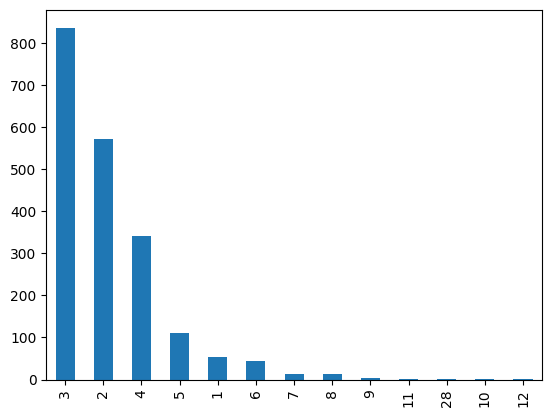

In [11]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

#### Scaling and imputing

Scale values as (x-min(x))/(max(x)-min(x))

Impute NaN values using MICE method with IterativeImputer on Linear regression as estimator 

In [9]:
columns, index = dinam_fact_df.columns, dinam_fact_df.index

scal_model = MinMaxScaler()
scal_model = scal_model.fit(dinam_fact_df)
pickle.dump(scal_model.__getstate__(), open("models/minmax_scaler.pkl", 'wb'))
df_scaled = scal_model.transform(dinam_fact_df)

# TBD: need experiments
imp = IterativeImputer(estimator=LinearRegression(),
     missing_values=np.nan, max_iter=10, imputation_order='roman')
imp = imp.fit(df_scaled)
pickle.dump(imp.__getstate__(), open("models/iterative_imputer.pkl", 'wb'))
df_imputed = imp.transform(df_scaled)

dinam_fact_df = pd.DataFrame(data=df_imputed, columns = columns, index = index)
dinam_fact_df

d:\covid\covid\venv\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                      0.354167               0.012409   
        1                      0.270833               0.012896   
        2                      0.333333               0.013803   
        3                      0.312500               0.013733   
GACAAnf 0                      0.354510               0.007389   
...                                 ...                    ...   
GACBB;O 0                      0.395833               0.007459   
        1                      0.312500               0.010457   
GACXAAB 0                      0.312500               0.006692   
        1                      0.395833               0.010108   
        2                      0.333333               0.023005   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0              0.012004        0.496644        0.125000   
        1              0.011022        0.476510        0.093750   
        2              0.013833        0.481220        0.087500   
        3              0.011602        0.476510        0.087500   
GACAAnf 0              0.008791        0.369128        0.112500   
...                         ...             ...             ...   
GACBB;O 0              0.009523        0.362416        0.087500   
        1              0.108447        0.465736        0.081250   
GACXAAB 0              0.009282        0.466296        0.098837   
        1              0.026685        0.503356        0.075000   
        2              0.007229        0.490074        0.068750   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                          0.118339   
        1                          0.093260   
        2                          0.080601   
        3                          0.087013   
GACAAnf 0                          0.059561   
...                                     ...   
GACBB;O 0                          0.009639   
        1                          0.028056   
GACXAAB 0                          0.033699   
        1                          0.007053   
        2                          0.071317   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                       0.578125   
        1                                       0.531250   
        2                                       0.562500   
        3                                       0.593750   
GACAAnf 0                                       0.335938   
...                                                  ...   
GACBB;O 0                                       0.250000   
        1                                       0.265625   
GACXAAB 0                                       0.531250   
        1                                       0.546875   
        2                                       0.484375   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                          0.101604               0.497343   
        1                          0.165775               0.310308   
        2                          0.197861               0.229543   
        3                          0.101604               0.240170   
GACAAnf 0                          0.209626               0.240170   
...                                     ...                    ...   
GACBB;O 0                          0.137968               0.334750   
        1                          0.219251               0.421892   
GACXAAB 0                          0.208556               0.183847   
        1                          0.283422               0.121148   
        2                          0.294118          

In [60]:
def df_to_X_y(df, window=3):
    X, y = [], []
    df_grouped = df.groupby("case").size()
    df_idx = df_grouped[df_grouped==window+1].index #Select windows with size window
    for i in df_idx:
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy())
        y.append(df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = df_to_X_y(dinam_fact_df, 3)
X.shape

(341, 3, 13)

Divide on train, test, validation splits

In [174]:
def split_train_test(X, y, test_size=0.2):   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=1/2)
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)
(X_train, y_train), (X_test, y_test), (X_val, y_val) = split_train_test(X, y)
(X_test, y_test), (X_val, y_val) = (X_test[:-2], y_test[:-2]), (X_val[:-3], y_val[:-3])
print("TRAIN shape: ", X_train.shape)
print("TEST shape: ", y_test.shape)
print("VAL shape: ", y_val.shape)

TRAIN shape:  (272, 3, 13)
TEST shape:  (32, 13)
VAL shape:  (32, 13)


Summarize preparation function

In [112]:
def prepare_data(df_input, scaler_path, imputer_path, window=3, test_size=1/11):
    state = pickle.load(open(scaler_path, 'rb'))
    scal_model = MinMaxScaler()
    scal_model.__setstate__(state)
    df_scaled = scal_model.transform(df_input)

    state = pickle.load(open(imputer_path, 'rb'))
    imputer = IterativeImputer()
    imputer.__setstate__(state)
    df_imputed = imputer.transform(df_scaled)

    X, y = df_to_X_y(df_imputed, window)
    (X_train, y_train), (X_test, y_test), (X_val, y_val) = split_train_test(X, y, test_size)
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)


## Training

#### Function which shows results of model

In [128]:
# Function which shows results of model
def show_results(X_test, y_test, model, history, scal_model_path="models/minmax_scaler.pkl", batch_size=None, sample_num = 0):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"])

    state = pickle.load(open(scal_model_path, 'rb'))
    scaler = MinMaxScaler()
    scaler.__setstate__(state)
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)
    predicted_values = scaler.inverse_transform(y_pred)
    real_values = scaler.inverse_transform(y_test)
    last_values = scaler.inverse_transform(X_test[sample_num])

    r2_scor = r2_score(real_values, predicted_values, multioutput="raw_values")
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")

    table=[]
    table.extend(last_values)
    table.append(real_values[sample_num])
    table.append(predicted_values[sample_num])
    table.append(mse_score)
    table.append(r2_scor)

    df = pd.DataFrame(table, index=[*["prev"]*len(last_values),
        "real", "predicted", "MSE", "R2"], columns=dinam_fact_df.columns)

    display(df)
    plt.show()
    

In [40]:
PARAMS_LENGTH = 13
WINDOW = 3

### One layer RNN size 13

Simple RNN with state units 13 and relu activation between layers and linear activation on last layer

In [180]:
model = Sequential(name="RNN13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse")
model_simple_rnn_13.summary()

Model: "RNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 13)                351       
                                                                 
 dense_21 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


Lets show learning history for the model. We see intersection on 15 epochs - model becomes overfit.

In [181]:
history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=50, shuffle=False, validation_data=(X_val, y_val), verbose=0)
model_simple_rnn_13.save("models/minmax_scaler/RNN13")

INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13\assets


Lets show on table what we have predicted:

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.400000,7.460164,96.216976,76.000000,20.039909,9.460000,7.100000,0.241367,29.967402,0.000000,2.000000,302.410000,14.700000
prev,36.700000,9.041745,120.880249,72.689824,18.850625,7.070000,10.100000,0.457882,31.127574,0.000000,5.000000,380.000000,11.800000
prev,36.700000,8.679697,66.800986,76.000000,19.000000,11.200000,10.100000,0.335161,30.713227,0.000000,5.000000,253.000000,11.500000
real,36.500000,9.127494,66.800986,85.000000,17.000000,18.700000,9.500000,0.247503,30.630357,0.000000,5.000000,294.000000,10.800000
predicted,36.382309,7.041568,113.707085,68.930992,30.054081,8.936335,9.606424,0.278305,34.999966,0.109687,4.783207,467.141846,15.176437
MSE,0.001935,0.001399,0.001173,0.005803,0.002336,0.019888,0.007449,0.007917,0.010260,0.011219,0.014713,0.002986,0.012478
R2,-0.611161,-96.272444,0.546537,-0.788660,-12.199507,-0.022927,0.279602,-1.050437,-0.468266,0.629401,-1.494408,-0.502677,0.055082


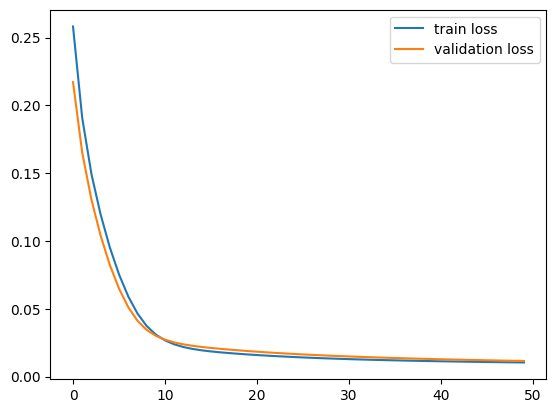

In [182]:
show_results(X_test, y_test, model_simple_rnn_13, history, sample_num=1)

RNN with sigmoid

INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13_sigmoid\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.542141,7.945818,118.390724,71.175102,16.651035,12.908584,9.338012,0.301767,37.258148,0.135801,4.551140,258.403290,15.024056
MSE,0.002123,0.000436,0.003895,0.003856,0.001281,0.019381,0.010805,0.003681,0.006763,0.006624,0.010925,0.002238,0.014235
R2,-0.767461,-29.289596,-0.505430,-0.188681,-6.240411,0.003132,-0.044907,0.046718,0.032157,0.781200,-0.852182,-0.125986,-0.077919


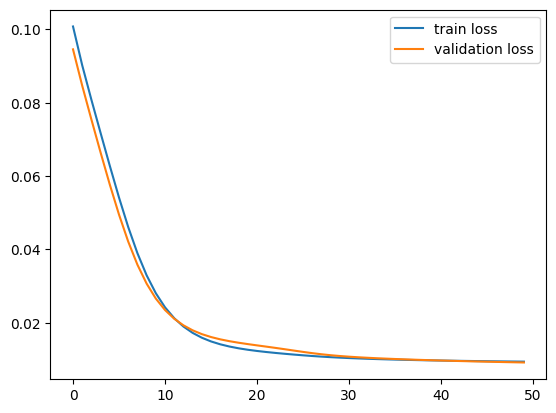

In [183]:
name = "RNN13_sigmoid"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse")

history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=50, shuffle=False, validation_data=(X_val, y_val), verbose=0)
model_simple_rnn_13.save(f"models/minmax_scaler/{name}")

show_results(X_test, y_test, model_simple_rnn_13, history)

INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13_relu\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.388737,15.706629,14.667709,69.932693,18.168600,8.210221,9.135289,0.283404,36.533943,0.079824,4.307944,389.128876,16.155178
MSE,0.003314,0.001514,0.007226,0.006609,0.001606,0.006380,0.012363,0.005249,0.006367,0.007889,0.011464,0.007022,0.009304
R2,-1.758582,-104.280870,-1.792924,-1.037197,-8.073975,0.671831,-0.195564,-0.359535,0.088835,0.739406,-0.943606,-2.533249,0.295469


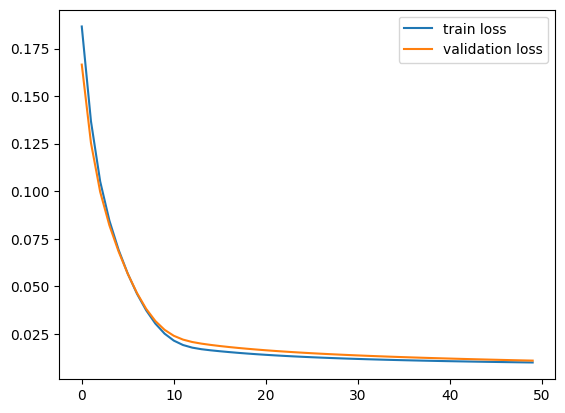

In [184]:
name = "RNN13_relu"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse")

history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=50, shuffle=False, validation_data=(X_val, y_val), verbose=0)
model_simple_rnn_13.save(f"models/minmax_scaler/{name}")

show_results(X_test, y_test, model_simple_rnn_13, history)

Using sigmoid function we see that our model is fitted (see graph)

### LSTM

Model LSTM with 13 units as state

Model: "LSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 13)                1404      
                                                                 
 dense_25 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: LSTM13\assets


INFO:tensorflow:Assets written to: LSTM13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.540314,3.155257,61.755249,71.379005,15.612888,9.613486,9.258611,0.310690,37.886070,0.109091,4.693851,290.121033,16.906361
MSE,0.001496,0.000689,0.002431,0.003172,0.000473,0.017826,0.010777,0.004245,0.006081,0.008936,0.012462,0.002920,0.008065
R2,-0.245810,-46.947740,0.060228,0.022365,-1.671874,0.083095,-0.042206,-0.099420,0.129831,0.704818,-1.112789,-0.469532,0.389257


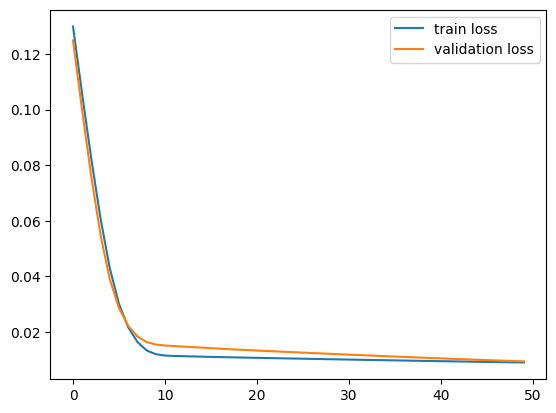

In [186]:
model = Sequential(name="LSTM13")
model.add(Input((3, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_13 = model
model_lstm_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13.summary()
history = model_lstm_13.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val),
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13")
show_results(X_test, y_test, model_lstm_13, history)

#### LSTM with batch

Model: "LSTM13Batch12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (8, 13)                   1404      
                                                                 
 dense_26 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: LSTM13Batch12\assets


INFO:tensorflow:Assets written to: LSTM13Batch12\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.581947,8.165858,90.540688,76.146469,19.359467,10.840415,7.982979,0.300899,38.963524,0.120502,4.832484,294.343292,17.662922
MSE,0.001449,0.000060,0.003991,0.002715,0.000458,0.014396,0.006777,0.003343,0.006053,0.001621,0.010020,0.002415,0.006708
R2,-0.206403,-3.199845,-0.542361,0.163053,-1.586388,0.259534,0.344595,0.134121,0.133814,0.946451,-0.698708,-0.215382,0.492053


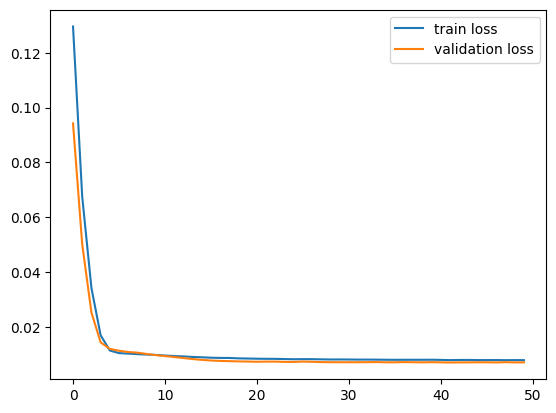

In [187]:
BATCH_SIZE=8
name = "LSTM13Batch12"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_13_b12 = model
model_lstm_13_b12.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13_b12.summary()
history = model_lstm_13_b12.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
model_lstm_13.save(name)
show_results(X_test, y_test, model_lstm_13_b12, history, batch_size=BATCH_SIZE)

#### LSTM64 Encoder + LSTM 13 Decoder 

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 3, 64)             19968     
                                                                 
 lstm_26 (LSTM)              (None, 13)                4056      
                                                                 
 dense_27 (Dense)            (None, 13)                182       
                                                                 
Total params: 24,206
Trainable params: 24,206
Non-trainable params: 0
_________________________________________________________________
None


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.599529,6.814276,57.444714,70.030838,18.113878,12.030645,8.561325,0.296369,37.485359,0.168894,4.560644,292.613708,16.368732
MSE,0.001348,0.000262,0.003316,0.002968,0.000213,0.019896,0.007342,0.003898,0.005766,0.002082,0.010289,0.002624,0.008223
R2,-0.122225,-17.202244,-0.281658,0.085017,-0.205123,-0.023342,0.290015,-0.009505,0.174807,0.931228,-0.744294,-0.320512,0.377297


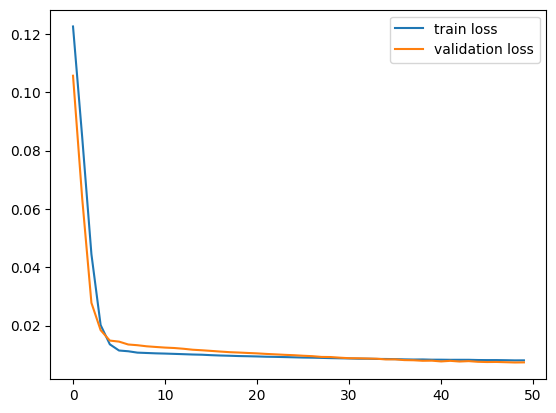

In [188]:

model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_64_encod = model
model_lstm_64_encod.compile(optimizer="adam", loss="mse")
print(model_lstm_64_encod.summary())
history = model_lstm_64_encod.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), verbose=0)

show_results(X_test, y_test, model_lstm_64_encod, history, batch_size=BATCH_SIZE)

Model: "LSTM13Batch12Tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (8, 13)                   1404      
                                                                 
 dense_28 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: LSTM13Batch12Tanh\assets


INFO:tensorflow:Assets written to: LSTM13Batch12Tanh\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.633213,8.621144,80.751366,74.755417,17.713295,9.488062,7.907851,0.303713,37.309494,0.043941,4.646734,297.829163,17.694330
MSE,0.001550,0.000017,0.003382,0.002821,0.000642,0.018131,0.006019,0.003696,0.005034,0.001337,0.010389,0.003058,0.006322
R2,-0.290246,-0.163703,-0.307005,0.130391,-2.625944,0.067420,0.417943,0.042779,0.279528,0.955850,-0.761331,-0.538785,0.521286


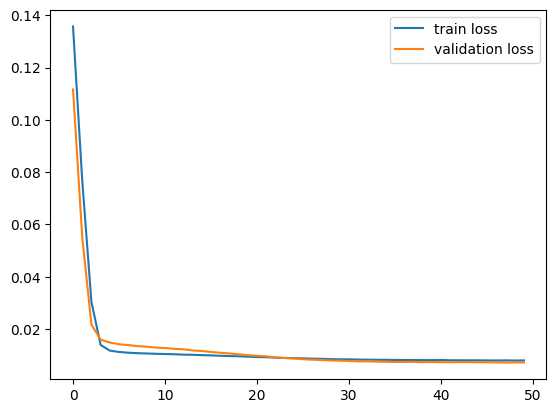

In [189]:
name = "LSTM13Batch12Tanh"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="tanh"))
model_lstm_13_b12 = model
model_lstm_13_b12.compile(optimizer="adam", loss="mse")
model_lstm_13_b12.summary()
history = model_lstm_13_b12.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
model_lstm_13.save(name)
show_results(X_test, y_test, model_lstm_13_b12, history, batch_size=BATCH_SIZE)

## Train with static parameters


Lets define new function for splitting

In [113]:
def prepare_data_with_static(df, scaler_path, imputer_path, window=3, test_size=0.2):
    X, y = [], []
    df_grouped = df.groupby(["case"]).size()
    df_idx = df_grouped[df_grouped==window+1].index
    state = pickle.load(open(scaler_path, 'rb'))
    scal_model = MinMaxScaler()
    scal_model.__setstate__(state)
    df_scaled = scal_model.transform(df.iloc[:, 29:42])
    state = pickle.load(open(imputer_path, 'rb'))
    imputer = IterativeImputer()
    imputer.__setstate__(state)
    df_imputed = imputer.transform(df_scaled)
    df.iloc[:, 29:42] = df_imputed
    for i in df_idx:
        wind = df.loc[(i, 0): (i, window-1)]
        sample_data = wind.iloc[:, 0:29].to_numpy() # medicines
        sample_data = np.hstack([sample_data, wind.iloc[:, 29:42].to_numpy()]) # facts
        sample_data = np.hstack([sample_data, wind.iloc[:, 42:43].to_numpy()]) # age
        sample_data = np.hstack([sample_data, wind.iloc[:, 43:47].to_numpy()])# controls
        X.append(sample_data)
        y.append(df.loc[(i, window)].iloc[29:42].to_numpy())
    X, y = np.array(X), np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=1/2)
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)

(X_train, y_train), (X_test, y_test), (X_val, y_val) = prepare_data_with_static(df, "models/minmax_scaler.pkl", "models/iterative_imputer.pkl", window=3)

In [45]:
print(X_train.shape,
X_val.shape,
X_test.shape)
print(y_train.shape,
y_val.shape,
y_test.shape)

(272, 3, 47) (35, 3, 47) (34, 3, 47)
(272, 13) (35, 13) (34, 13)


Now we have such dinam_facts and dinam_controls frame:

In [110]:
S = np.delete(X_train, np.s_[29:42], 2)
D = X_train[:, :, 29:42]

And frame with information about medicines and age:

In this model we pass static data first to Dense layer, and dinamic timesteps to LSTM. Combined results are processed by Dense layer

In [58]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=3

In [121]:
name = "LSTMStatDynam"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val))
model_lstm_13.save(name)
show_results(X_test, y_test, model_lstm, history, batch_size=BATCH_SIZE)

Model: "LSTMStatDynam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 47)                17860     
                                                                 
 dense_8 (Dense)             (None, 13)                624       
                                                                 
Total params: 18,484
Trainable params: 18,484
Non-trainable params: 0
_________________________________________________________________


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [108]:
arr = [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5]]


[[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5]]

In [35]:
input_static = Input((30))
input_dinamic = Input((3, 17))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(17, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(lstm_layer)
model_multi = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi.summary()
model_multi.compile(optimizer="adam", loss="mse")

history = model_multi.fit(x=[T, X], y=y, validation_data=([T_t, X_t], y_t), epochs=80)
model_multi.save("Multimodal_DenseLSTM")

history = model_multi.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=80)
model_multi.save("LSTM+Static")
show_results(X_test, y_test, model_multi, history)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3, 17)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 17)           2380        ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 13)           234         ['lstm_1[0][0]']                 
                                                                                            

NameError: name 'T' is not defined

Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-6.535211,-0.038425,0.246508,-11.381865,-0.421314,-0.469539,-0.083432,-1.953321,-0.740843,-2.192207,-5.519806,-1.609487,0.275814


4/4 [==============================] - 0s 2ms/step - loss: 0.3875 - root_mean_squared_error: 0.6225
[('loss', 0.38748931884765625), ('root_mean_squared_error', 0.6224863529205322)]
-2.3402405098952297


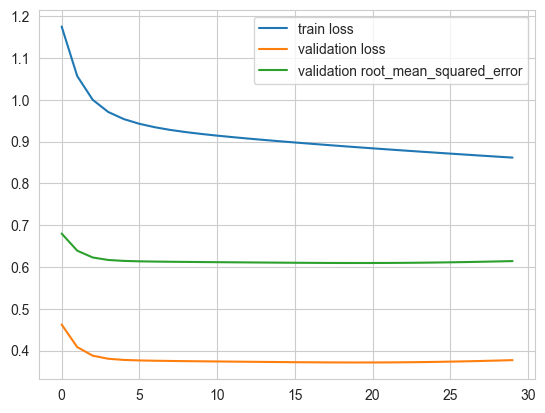

In [583]:
show_results_multimodal(X_t, T_t, y_t, model_multi, history)

As we see here, model is fitted, with RMSE 0.62, but R2 scores are negative

Here we save all states from LSTM cells, concatenate them and give to last dense layers as params

In [553]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(16, return_state=True)(input_dinamic)
flat_lst_layer = concatenate(lstm_layer)
result_layer = Dense(32, activation='relu')(concatenate([flat_lst_layer, dense_layer]))
result_layer = Dense(13, activation='tanh')(result_layer)
model_multi_s2 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s2.summary()
model_multi_s2.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_153 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 lstm_95 (LSTM)                 [(12, 32),           6400        ['input_153[0][0]']              
                                 (12, 32),                                                        
                                 (12, 32)]                                                        
                                                                                                  
 input_152 (InputLayer)         [(12, 30)]           0           []                               
                                                                                           

Epoch 1/80
35/35 [==============================] - 3s 24ms/step - loss: 1.7418 - root_mean_squared_error: 1.3198 - val_loss: 1.5128 - val_root_mean_squared_error: 1.2300
Epoch 2/80
35/35 [==============================] - 0s 6ms/step - loss: 1.2952 - root_mean_squared_error: 1.1381 - val_loss: 1.2015 - val_root_mean_squared_error: 1.0961
Epoch 3/80
35/35 [==============================] - 0s 8ms/step - loss: 1.1214 - root_mean_squared_error: 1.0589 - val_loss: 1.0634 - val_root_mean_squared_error: 1.0312
Epoch 4/80
35/35 [==============================] - 0s 7ms/step - loss: 0.9722 - root_mean_squared_error: 0.9860 - val_loss: 0.9631 - val_root_mean_squared_error: 0.9814
Epoch 5/80
35/35 [==============================] - 0s 5ms/step - loss: 0.9356 - root_mean_squared_error: 0.9672 - val_loss: 0.9666 - val_root_mean_squared_error: 0.9832
Epoch 6/80
35/35 [==============================] - 0s 5ms/step - loss: 0.9292 - root_mean_squared_error: 0.9640 - val_loss: 0.9557 - val_root_mean_s

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-3.744282,0.004969,0.072795,-4.63449,0.100809,-1.11893,-0.080378,-0.389847,-0.710452,-2.223323,-1.121214,-0.901408,0.259923


4/4 [==============================] - 0s 3ms/step - loss: 0.4272 - root_mean_squared_error: 0.6536
[('loss', 0.42718935012817383), ('root_mean_squared_error', 0.6535972356796265)]


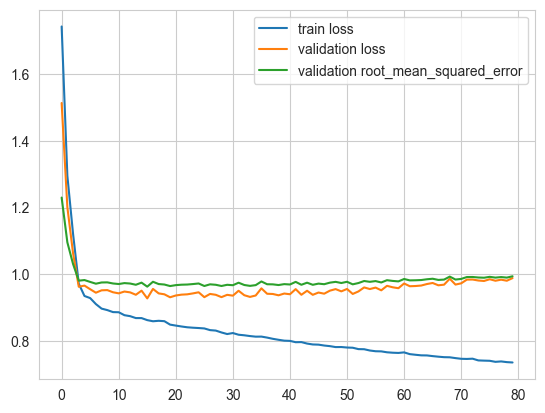

In [554]:
history = model_multi_s2.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=80)


Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-3.744282,0.004969,0.072795,-4.63449,0.100809,-1.11893,-0.080378,-0.389847,-0.710452,-2.223323,-1.121214,-0.901408,0.259923


4/4 [==============================] - 0s 2ms/step - loss: 0.4272 - root_mean_squared_error: 0.6536
[('loss', 0.42718935012817383), ('root_mean_squared_error', 0.6535972356796265)]
-1.1142943949879738


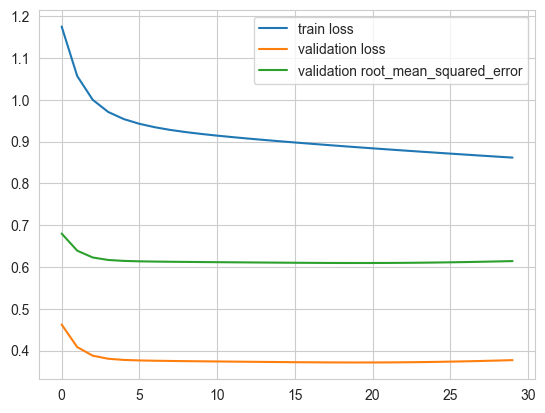

In [584]:
show_results_multimodal(X_t, T_t, y_t, model_multi_s2, history)

Lets use linear activation to compare results

In [549]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(32, activation='relu')(input_static)
dense_layer = Dense(12, activation='relu')(input_static)
lstm_layer = LSTM(17, return_state=False)(input_dinamic)
result_layer = Dense(32)(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s3 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s3.summary()
model_multi_s3.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_149 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 input_148 (InputLayer)         [(12, 30)]           0           []                               
                                                                                                  
 lstm_93 (LSTM)                 (12, 17)             2380        ['input_149[0][0]']              
                                                                                                  
 dense_171 (Dense)              (12, 12)             372         ['input_148[0][0]']              
                                                                                           

Epoch 1/100
35/35 [==============================] - 3s 16ms/step - loss: 37.6398 - root_mean_squared_error: 6.1351 - val_loss: 2.9339 - val_root_mean_squared_error: 1.7129
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 1.5276 - root_mean_squared_error: 1.2360 - val_loss: 1.3489 - val_root_mean_squared_error: 1.1614
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 1.1798 - root_mean_squared_error: 1.0862 - val_loss: 1.1890 - val_root_mean_squared_error: 1.0904
Epoch 4/100
35/35 [==============================] - 0s 6ms/step - loss: 1.1394 - root_mean_squared_error: 1.0674 - val_loss: 1.1589 - val_root_mean_squared_error: 1.0765
Epoch 5/100
35/35 [==============================] - 0s 6ms/step - loss: 1.1093 - root_mean_squared_error: 1.0532 - val_loss: 1.1204 - val_root_mean_squared_error: 1.0585
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 1.0797 - root_mean_squared_error: 1.0391 - val_loss: 1.1111 - val_root

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-5.767069,-0.100873,0.416566,-7.912596,0.154873,-0.092809,0.409737,-1.996667,-0.992398,0.88557,-6.84056,-0.340282,0.484316


4/4 [==============================] - 0s 6ms/step - loss: 0.5188 - root_mean_squared_error: 0.7203
[('loss', 0.518792450428009), ('root_mean_squared_error', 0.7202724814414978)]


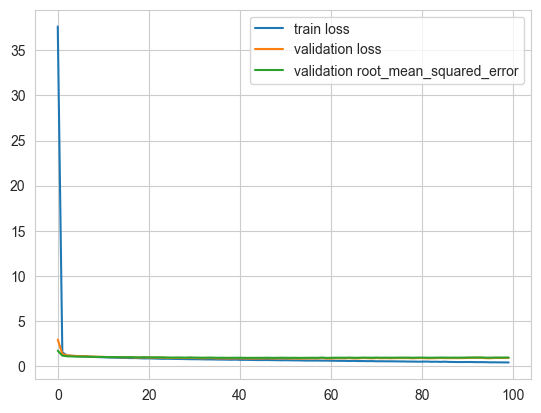

In [550]:
history = model_multi_s3.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=100)

Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-5.767069,-0.100873,0.416566,-7.912596,0.154873,-0.092809,0.409737,-1.996667,-0.992398,0.88557,-6.84056,-0.340282,0.484316


4/4 [==============================] - 0s 2ms/step - loss: 0.5188 - root_mean_squared_error: 0.7203
[('loss', 0.518792450428009), ('root_mean_squared_error', 0.7202724814414978)]
-1.6686300805545702


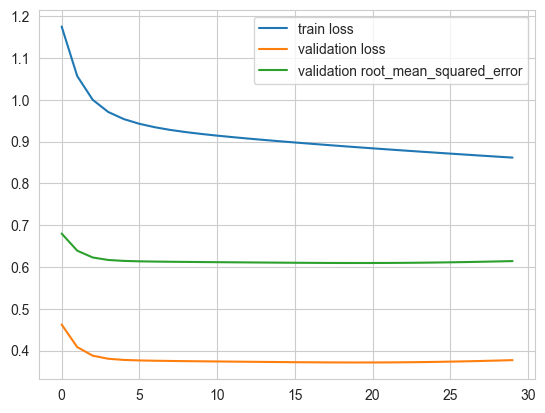

In [585]:
show_results_multimodal(X_t, T_t, y_t, model_multi_s3, history)

With linear activation, model seems to be more adequate, as more r2 scores are positive.

Here we add additional layerto information data

In [561]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(30, activation='relu')(input_static)
dense_layer = Dense(12, activation='relu')(input_static)
lstm_layer = LSTM(16, return_state=False)(input_dinamic)
result_layer = Dense(32)(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s4 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s4.summary()
model_multi_s4.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_163 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 input_162 (InputLayer)         [(12, 30)]           0           []                               
                                                                                                  
 lstm_100 (LSTM)                (12, 16)             2176        ['input_163[0][0]']              
                                                                                                  
 dense_189 (Dense)              (12, 12)             372         ['input_162[0][0]']              
                                                                                           

Epoch 1/40
35/35 [==============================] - 3s 23ms/step - loss: 13.4925 - root_mean_squared_error: 3.6732 - val_loss: 1.8562 - val_root_mean_squared_error: 1.3624
Epoch 2/40
35/35 [==============================] - 0s 9ms/step - loss: 1.3076 - root_mean_squared_error: 1.1435 - val_loss: 1.2495 - val_root_mean_squared_error: 1.1178
Epoch 3/40
35/35 [==============================] - 0s 7ms/step - loss: 1.1512 - root_mean_squared_error: 1.0729 - val_loss: 1.1630 - val_root_mean_squared_error: 1.0784
Epoch 4/40
35/35 [==============================] - 0s 7ms/step - loss: 1.1198 - root_mean_squared_error: 1.0582 - val_loss: 1.1587 - val_root_mean_squared_error: 1.0764
Epoch 5/40
35/35 [==============================] - 0s 6ms/step - loss: 1.0891 - root_mean_squared_error: 1.0436 - val_loss: 1.0998 - val_root_mean_squared_error: 1.0487
Epoch 6/40
35/35 [==============================] - 0s 7ms/step - loss: 1.0525 - root_mean_squared_error: 1.0259 - val_loss: 1.0671 - val_root_mean_

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-9.97125,-0.012811,0.223352,-13.352751,-1.489457,-0.262107,0.330958,-3.347081,-0.81529,0.812381,-9.289847,-1.842228,0.528473


4/4 [==============================] - 0s 6ms/step - loss: 0.4660 - root_mean_squared_error: 0.6826
[('loss', 0.4660094976425171), ('root_mean_squared_error', 0.6826488375663757)]


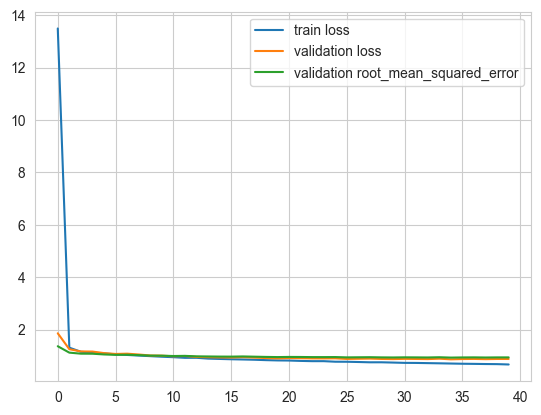

In [562]:
history = model_multi_s4.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=40)
show_results_multimodal(X_t, T_t, y_t, model_multi_s4, history)

In result we do not see some improvements with this method

And now we can multiply DENSE output and put it to LSTM cells, so each timestep will know information about treatment.
...TBD